# Multiclass Classification

## Library and Dataset import

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import os
import json
import joblib
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
)
from statsmodels.stats.contingency_tables import mcnemar
import gensim

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.w2v_feature_extraction import compute_w2v_features

df_train = pd.read_csv("../dataset/training_set.csv")
df_train.head()
X_text = df_train["text"]
y_binary = df_train["multiclass_label"]

## Not_cyberbulling pruning & Feature Extraction

In [3]:
# not_cyberbullying pruning 

df_filtered = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy()

label2id = {label: idx for idx, label in enumerate(sorted(df_filtered["multiclass_label"].unique()))}
id2label = {v: k for k, v in label2id.items()}

df_filtered["label_id"] = df_filtered["multiclass_label"].map(label2id)

X_text_pruned = df_filtered["text"]
y_multiclass = df_filtered["label_id"]

print("Final Classes:", label2id)
print("Classe Distribution:")
print(df_filtered["multiclass_label"].value_counts())

# Feature extraction 

# BoW
bow_vectorizer = CountVectorizer(max_features=350)
X_bow = bow_vectorizer.fit_transform(X_text_pruned)
joblib.dump(bow_vectorizer, "../model/bow_vocabulary_multiclass.pkl")

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=350)
X_tfidf = tfidf_vectorizer.fit_transform(X_text_pruned)
joblib.dump(tfidf_vectorizer, "../model/tfidf_vocabulary_multiclass.pkl")

# Load Word2Vec models
model1 = Word2Vec.load("../model/word2vec_model1.model")
model2 = Word2Vec.load("../model/word2vec_model2.model")

X_w2v1 = compute_w2v_features(X_text_pruned, model1, model1.vector_size)
X_w2v2 = compute_w2v_features(X_text_pruned, model2, model2.vector_size)

Final Classes: {'age': 0, 'ethnicity': 1, 'gender': 2, 'other_cyberbullying': 3, 'religion': 4}
Classe Distribution:
multiclass_label
religion               6398
age                    6393
ethnicity              6368
gender                 6354
other_cyberbullying    6081
Name: count, dtype: int64


## GRID search

In [ ]:
os.makedirs("../model", exist_ok=True)
results_list = []

# Hyperparameter Grid
param_grid = {
    "LogisticRegression": {
        "model__C": [0.01, 1, 10]
    },
    "LinearSVM": {
        "model__C": [0.01, 0.1, 1, 10]
    },
    "RandomForest": {
        "model__n_estimators": [100, 200, 500, 1000],
        "model__max_depth": [None, 10, 20],
        "model__random_state": [42]
    }
}

# Selected model
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LinearSVM": LinearSVC(max_iter=10000),
    "RandomForest": RandomForestClassifier()
}

# Vectorization method
datasets = {
    "BoW": X_bow,
    "TF-IDF": X_tfidf,
    "W2V-1": X_w2v1,
    "W2V-2": X_w2v2
}

y = y_multiclass

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision_macro",
    "recall": "recall_macro",
    "f1": "f1_macro"
}

for vectorizer_name, X in datasets.items():
    for model_name, model in models.items():
        
        steps = []
        if "W2V" in vectorizer_name:
            steps.append(("scaler", StandardScaler()))
        steps.append(("model", model))
        pipeline = Pipeline(steps)

        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid[model_name],
            cv=cv_strategy,
            scoring=scoring,
            refit="accuracy",
            n_jobs=-1,
            verbose=1
        )

        grid.fit(X, y)

        model_path = f"../model/grid_search_multiclass/{model_name}_{vectorizer_name}_multiclass.pkl"
        joblib.dump(grid.best_estimator_, model_path)

        best_idx = grid.best_index_
        results_list.append({
            "model": model_name,
            "vectorizer": vectorizer_name,
            "accuracy": grid.cv_results_["mean_test_accuracy"][best_idx],
            "precision": grid.cv_results_["mean_test_precision"][best_idx],
            "recall": grid.cv_results_["mean_test_recall"][best_idx],
            "f1": grid.cv_results_["mean_test_f1"][best_idx]
        })

with open("../model/grid_search_multiclass/results_multiclass.json", "w") as f:
    json.dump(results_list, f, indent=2)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


## K-fold Cross Validation and Model Evaluation

In [4]:
# Dataset
datasets = {
    "BoW": X_bow,
    "TF-IDF": X_tfidf,
    "W2V-1": X_w2v1,
    "W2V-2": X_w2v2
}
y = y_multiclass  

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average="macro", zero_division=0),
    "recall": make_scorer(recall_score, average="macro", zero_division=0),
    "f1": make_scorer(f1_score, average="macro", zero_division=0)
}

model_dir = "../model/grid_search_multiclass"
eval_results = []

for fname in os.listdir(model_dir):
    if fname.endswith(".pkl") and "_" in fname:
        model_name, vectorizer_name, _ = fname.replace(".pkl", "").rsplit("_", 2)
        model_path = os.path.join(model_dir, fname)
        model = joblib.load(model_path)

        if vectorizer_name not in datasets:
            print(f"Dataset '{vectorizer_name}' not found.")
            continue

        X = datasets[vectorizer_name]

        try:
            scores = cross_validate(
                model,
                X,
                y,
                cv=cv,
                scoring=scoring,
                n_jobs=-1
            )
        except Exception as e:
            print(f"Error evaluating {model_name} with {vectorizer_name}: {e}")
            scores = {}

        result = {
            "model": model_name,
            "vectorizer": vectorizer_name
        }

        for key in ["accuracy", "precision", "recall", "f1"]:
            score_values = scores.get(f"test_{key}", [np.nan])
            mean_score = np.nanmean(score_values)
            result[key] = mean_score

            if np.isnan(mean_score):
                print(f" {model_name} + {vectorizer_name}: '{key}' is NaN")
        
        acc_values = scores.get("test_accuracy", [np.nan])
        result["accuracy_std"] = np.nanstd(acc_values)


        eval_results.append(result)

df_eval = pd.DataFrame(eval_results)
df_eval_sorted = df_eval.sort_values(by="accuracy", ascending=False)

display(df_eval_sorted)
df_eval_sorted.to_csv('../dataset/cross_validation/multiclass_result.csv', index=False)

,model,vectorizer,accuracy,precision,recall,f1,accuracy_std
11,RandomForest,TF-IDF,0.931474,0.933104,0.930990,0.931448,0.004228
5,LinearSVM,BoW,0.927929,0.931843,0.927713,0.928206,0.005030
3,LogisticRegression,BoW,0.927708,0.931015,0.927427,0.927908,0.004398
2,LinearSVM,TF-IDF,0.927233,0.929816,0.926868,0.927318,0.005492
6,RandomForest,BoW,0.926632,0.927850,0.926006,0.926510,0.003930
0,LogisticRegression,TF-IDF,0.926600,0.929670,0.926271,0.926805,0.005146
7,RandomForest,W2V-2,0.892860,0.898955,0.892517,0.892821,0.005962
9,RandomForest,W2V-1,0.892416,0.898642,0.892115,0.892470,0.005637
10,LinearSVM,W2V-1,0.882067,0.880832,0.880814,0.880339,0.005435
8,LinearSVM,W2V-2,0.881370,0.880225,0.880118,0.879648,0.006147



--- RandomForest + TF-IDF ---
Accuracy:             0.9334
Balanced Accuracy:    0.9330
Macro Precision:      0.9353
Macro Recall:         0.9330
Macro F1 Score:       0.9334


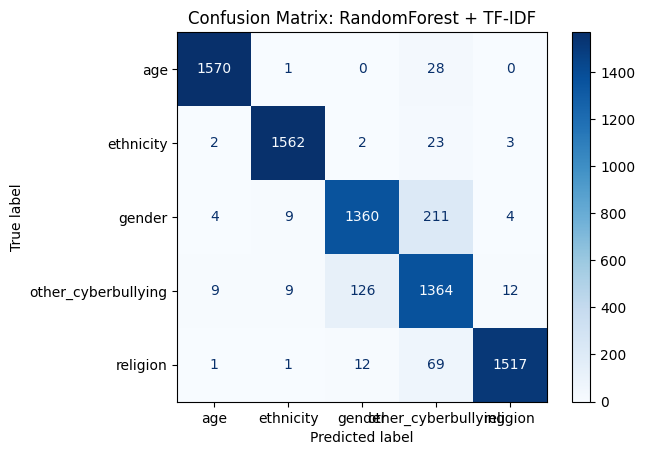


--- LinearSVM + BoW ---
Accuracy:             0.9278
Balanced Accuracy:    0.9276
Macro Precision:      0.9316
Macro Recall:         0.9276
Macro F1 Score:       0.9279


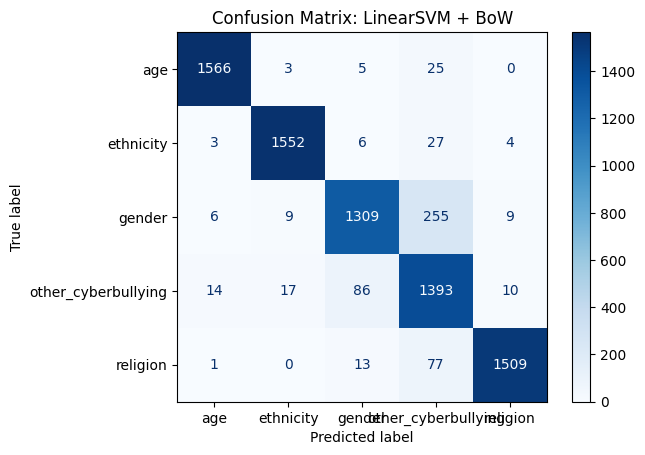


--- LogisticRegression + BoW ---
Accuracy:             0.9292
Balanced Accuracy:    0.9290
Macro Precision:      0.9321
Macro Recall:         0.9290
Macro F1 Score:       0.9292


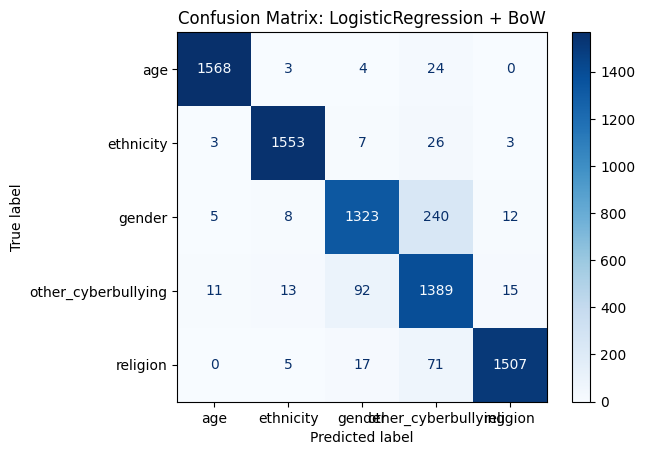


--- LinearSVM + TF-IDF ---
Accuracy:             0.9263
Balanced Accuracy:    0.9260
Macro Precision:      0.9288
Macro Recall:         0.9260
Macro F1 Score:       0.9262


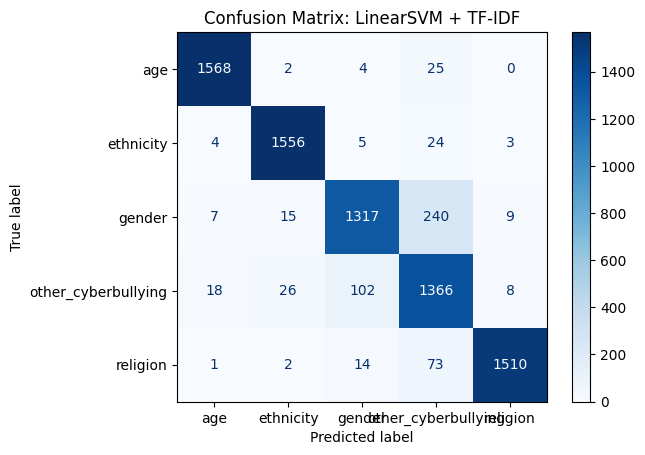


--- RandomForest + BoW ---
Accuracy:             0.9296
Balanced Accuracy:    0.9291
Macro Precision:      0.9310
Macro Recall:         0.9291
Macro F1 Score:       0.9295


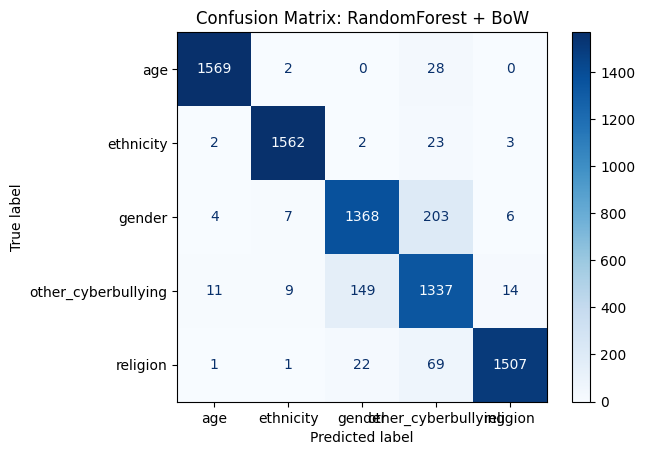


--- LogisticRegression + TF-IDF ---
Accuracy:             0.9261
Balanced Accuracy:    0.9257
Macro Precision:      0.9289
Macro Recall:         0.9257
Macro F1 Score:       0.9261


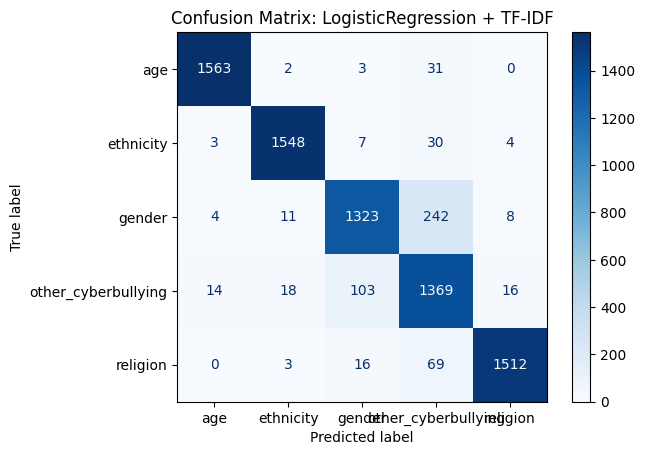


--- McNemar Test between Top 2 Models ---
McNemar's test statistic = 127.0, p-value = 0.0126
The difference is statistically significant.


In [ ]:
# test set loading
df_eval_sorted = pd.read_csv('../dataset/cross_validation/multiclass_result.csv')
df_test = pd.read_csv("../dataset/test_set.csv")
df_test = df_test[df_test["multiclass_label"] != "not_cyberbullying"]
X_test_text = df_test["text"]
y_test = df_test["multiclass_label"].map(label2id)

# Feature extraction 
tfidf_vectorizer = joblib.load("../model/tfidf_vocabulary_multiclass.pkl")
bow_vectorizer = joblib.load("../model/bow_vocabulary_multiclass.pkl")  

w2v_model_1 = gensim.models.Word2Vec.load("../model/word2vec_model1.model")  
w2v_model_2 = gensim.models.Word2Vec.load("../model/word2vec_model2.model")

X_test_tfidf = tfidf_vectorizer.transform(X_test_text)
X_test_bow = bow_vectorizer.transform(X_test_text)
X_test_w2v_1 = compute_w2v_features(X_test_text, w2v_model_1, w2v_model_1.vector_size)
X_test_w2v_2 = compute_w2v_features(X_test_text, w2v_model_2, w2v_model_2.vector_size)

# Dataset mapping
datasets = {
    "BoW": X_test_bow,
    "TF-IDF": X_test_tfidf,
    "W2V-1": X_test_w2v_1,
    "W2V-2": X_test_w2v_2
}

top_models = df_eval_sorted.head(6)

def print_metrics_and_confmat_multiclass(y_true, y_pred, labels, title):
    print(f"\n--- {title} ---")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f"Accuracy:             {acc:.4f}")
    print(f"Balanced Accuracy:    {bal_acc:.4f}")
    print(f"Macro Precision:      {prec:.4f}")
    print(f"Macro Recall:         {rec:.4f}")
    print(f"Macro F1 Score:       {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {title}")
    plt.show()


predictions = []

for _, row in top_models.iterrows():
    model_name = row["model"]
    vectorizer_name = row["vectorizer"]
    
    file_name = f"../model/grid_search_multiclass/{model_name}_{vectorizer_name}_multiclass.pkl"
    clf = joblib.load(file_name)
    
    X_input = datasets[vectorizer_name]
    
    y_pred = clf.predict(X_input)
    
    predictions.append(y_pred)
    
    print_metrics_and_confmat_multiclass(y_test, y_pred, list(label2id.keys()), f"{model_name} + {vectorizer_name}")

print("\n--- McNemar Test between Top 2 Models ---")
y_pred_1 = predictions[0]       
y_pred_2 = predictions[1]

b = np.sum((y_pred_1 == y_test) & (y_pred_2 != y_test))
c = np.sum((y_pred_1 != y_test) & (y_pred_2 == y_test))

table = [[0, b], [c, 0]]
result = mcnemar(table, exact=True)

print(f"McNemar's test statistic = {result.statistic}, p-value = {result.pvalue:.4f}")
if result.pvalue < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")
